In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc

import warnings 
warnings.filterwarnings('ignore')


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR  
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
pyodbc.drivers()

['SQL Server',
 'SQL Server Native Client RDA 11.0',
 'ODBC Driver 17 for SQL Server',
 'Microsoft Access Driver (*.mdb, *.accdb)',
 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)',
 'Microsoft Access Text Driver (*.txt, *.csv)',
 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']

In [3]:
# Eshtablishing the connection :

connection = pyodbc.connect(
    Trusted_Connection = "Yes",
    Driver = "{ODBC Driver 17 for SQL Server}",
    Server = "LAPTOP-6FTSTUVL\SQLEXPRESS",
    Database = "Store_Inventory"
)

* The pd.read_sql_query() function is part of the pandas library and is used to execute SQL queries and return the result set as a DataFrame. It simplifies the process of retrieving data for analysis by combining query execution and data loading into a single step.

In [4]:
data = pd.read_sql_query("SELECT * FROM dbo.retail_store_inventory_demand", connection)
data.head()

#Close connection
connection.close()

In [5]:
data.head()

,Date,Store_ID,Product_ID,Category,Region,Inventory_Level,Units_Sold,Units_Ordered,Demand_Forecast,Price,Discount,Weather_Condition,Holiday_Promotion,Competitor_Pricing,Seasonality,Revenue
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.470001,33.500000,20,Rainy,False,29.690001,Autumn,4254.500000
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.039993,63.009998,20,Sunny,False,66.160004,Autumn,9451.500000
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.019997,27.990000,10,Sunny,True,31.320000,Summer,1819.349976
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.180000,32.720001,10,Cloudy,True,34.740002,Autumn,1995.920044
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.260000,73.639999,0,Sunny,False,68.949997,Summer,1030.959961


### Key Data Features :
Date : Daily records from [start_date] to [end_date].

Store ID & Product ID : Unique identifiers for stores and products.

Category : Product categories like Electronics, Clothing, Groceries, etc.

Region : Geographic region of the store.

Inventory Level : Stock available at the beginning of the day.

Demand Forecast : 

Units Sold : Units sold during the day.

Weather Condition : Daily weather impacting sales.

Holiday/Promotion : Indicators for holidays or promotions.

### Exploring Data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store_ID            73100 non-null  object 
 2   Product_ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory_Level     73100 non-null  int64  
 6   Units_Sold          73100 non-null  int64  
 7   Units_Ordered       73100 non-null  int64  
 8   Demand_Forecast     73095 non-null  float64
 9   Price               72386 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather_Condition   73100 non-null  object 
 12  Holiday_Promotion   73100 non-null  bool   
 13  Competitor_Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
 15  Revenue             73100 non-null  float64
dtypes: b

In [7]:
# Checking the shape of the data.
data.shape

(73100, 16)

In [8]:
# Checking missings in the data
data.isna().sum()

Date                    0
Store_ID                0
Product_ID              0
Category                0
Region                  0
Inventory_Level         0
Units_Sold              0
Units_Ordered           0
Demand_Forecast         5
Price                 714
Discount                0
Weather_Condition       0
Holiday_Promotion       0
Competitor_Pricing      0
Seasonality             0
Revenue                 0
dtype: int64

In [9]:
# Since there is only one column with missing data and that is "Price". That too very little like not even 1 percent of the population
# That's why we'll remove those observations from the data

data.dropna(subset=['Price'], axis=0, how='any', inplace=True, ignore_index = True)
data.dropna(subset=['Demand_Forecast'], axis=0, how='any', inplace=True, ignore_index = True)

In [10]:
# Now the shape of the data has changed.
data.shape

(72381, 16)

In [11]:
# Checking duplicates in the data
data.duplicated().sum()

0

## Exploratory Data Analysis (EDA)
### Univariate & Multivariate Analysis

In [12]:
# Additional Data Information:

print("\nAdditional Statistics:")
print(f"Total number of stores: {data['Store_ID'].nunique()}")
print(f"Total number of products: {data['Product_ID'].nunique()}")
print(f"Total number of products category: {data['Category'].nunique()}")
print(f"Total number of regions: {data['Region'].nunique()}")
print(f"Date range: from {data['Date'].min()} to {data['Date'].max()}")


Additional Statistics:
Total number of stores: 5
Total number of products: 20
Total number of products category: 5
Total number of regions: 4
Date range: from 2022-01-01 to 2024-01-01


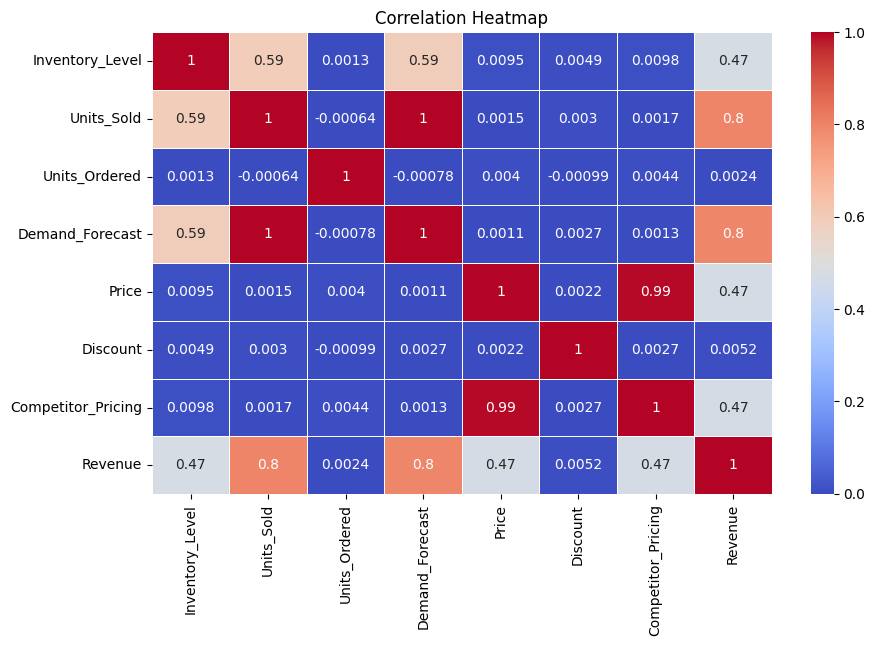

In [13]:
# Correlation among columns:

numeric_columns = data.select_dtypes(include=[np.number]).columns
correlation_matrix = data[numeric_columns].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [14]:
# Target variable description:
DemandDes = data['Demand_Forecast'].describe()
DemandDes

count    72381.000000
mean       141.465320
std        109.221797
min         -9.990000
25%         53.689999
50%        112.989998
75%        207.970001
max        518.549988
Name: Demand_Forecast, dtype: float64

#### From the DemandDes statistics, we can observe the following insights:

    Mean Demand: The average demand is around 141.49 units, indicating a moderate level of demand.
   
    Standard Deviation: The standard deviation of demand is 109.25 units, indicating a significant variation in demand.
   
    Minimum Demand: The minimum demand is -9.99 units, which might indicate errors in data collection or unusual circumstances.
    
    Maximum Demand: The maximum demand is 518.55 units, indicating a high demand scenario.
    
    Quartiles: The 25th percentile is 53.67 units, the median is 113.02 units, and the 75th percentile is 208.05 units, indicating a skewed distribution with a long tail towards higher demand.

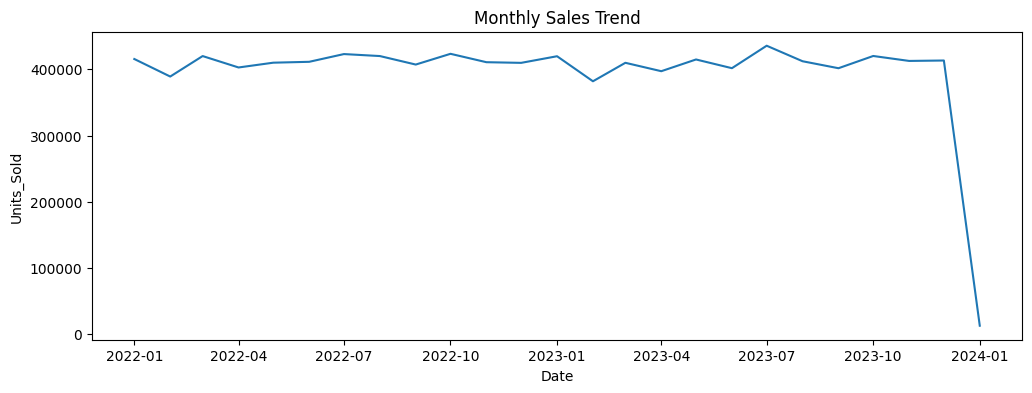

In [15]:
# Monthly sales trend :

data['Date']= pd.to_datetime(data['Date'])
monthly_sales = data.groupby(data['Date'].dt.to_period('M'))['Units_Sold'].sum().reset_index()
monthly_sales['Date'] = monthly_sales['Date'].dt.to_timestamp()
plt.figure(figsize=(12, 4))
plt.plot(monthly_sales['Date'], monthly_sales['Units_Sold'])
plt.title('Monthly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Units_Sold')
plt.show()

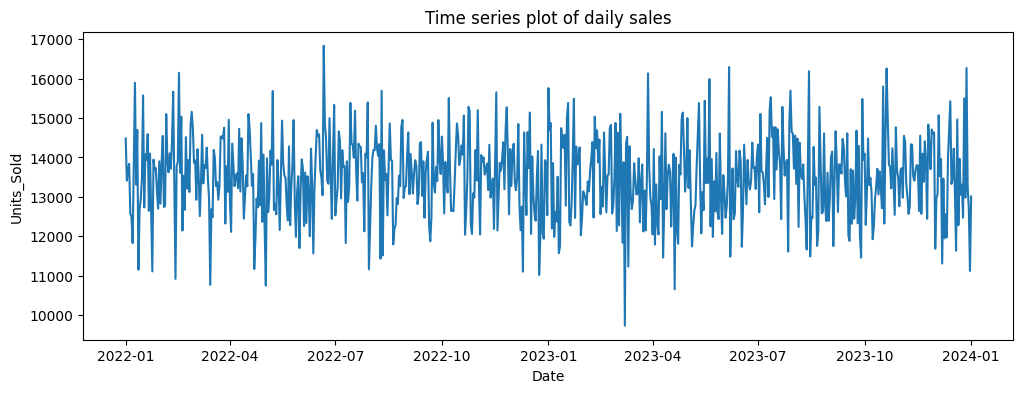

In [16]:
# Aggregate data by date
daily_sales = data.groupby('Date')['Units_Sold'].sum().reset_index()

# Plot daily sales
plt.figure(figsize=(12, 4))
plt.plot(daily_sales['Date'], daily_sales['Units_Sold'])
plt.title('Time series plot of daily sales')
plt.xlabel('Date')
plt.ylabel('Units_Sold')
plt.show()

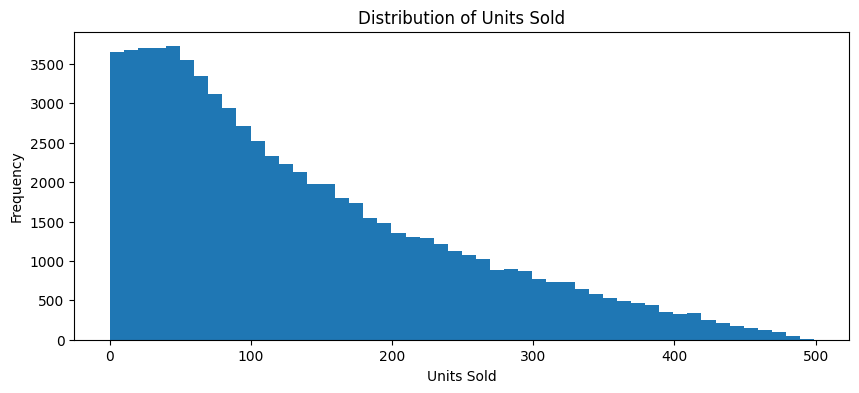

In [17]:
# Unit Sold distribution :

plt.figure(figsize=(10, 4))
plt.hist(data['Units_Sold'], bins=50)
plt.title('Distribution of Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.show()

In [18]:
# How many units from each category has been sold in every inventory in the given time period.

data.groupby(['Store_ID', 'Category'])['Units_Sold'].sum()

Store_ID  Category   
S001      Clothing       384282
          Electronics    385346
          Furniture      396195
          Groceries      393455
          Toys           395701
S002      Clothing       393068
          Electronics    390965
          Furniture      401811
          Groceries      394490
          Toys           389146
S003      Clothing       392486
          Electronics    396369
          Furniture      404661
          Groceries      399549
          Toys           409169
S004      Clothing       409420
          Electronics    383062
          Furniture      389707
          Groceries      400370
          Toys           376268
S005      Clothing       399041
          Electronics    386674
          Furniture      411789
          Groceries      392149
          Toys           400252
Name: Units_Sold, dtype: int64

In [19]:
# How many units in each season has been sold in every inventory in the given time period.

data.groupby(['Store_ID', 'Seasonality'])['Units_Sold'].sum()

Store_ID  Seasonality
S001      Autumn         491466
          Spring         483938
          Summer         487895
          Winter         491680
S002      Autumn         490116
          Spring         490982
          Summer         494946
          Winter         493436
S003      Autumn         501877
          Spring         514483
          Summer         487922
          Winter         497952
S004      Autumn         486834
          Spring         487723
          Summer         494477
          Winter         489793
S005      Autumn         511498
          Spring         485933
          Summer         487565
          Winter         504909
Name: Units_Sold, dtype: int64

In [20]:
# How many units in each weather condition has been sold in every inventory in the given time period.

data.groupby(['Store_ID', 'Weather_Condition'])['Units_Sold'].sum()

Store_ID  Weather_Condition
S001      Cloudy               505716
          Rainy                469442
          Snowy                480796
          Sunny                499025
S002      Cloudy               490478
          Rainy                483557
          Snowy                495033
          Sunny                500412
S003      Cloudy               490366
          Rainy                509686
          Snowy                493077
          Sunny                509105
S004      Cloudy               497924
          Rainy                480576
          Snowy                490807
          Sunny                489520
S005      Cloudy               488210
          Rainy                497598
          Snowy                498459
          Sunny                505638
Name: Units_Sold, dtype: int64

In [21]:
# Extracting the month :

data['Month'] = data['Date'].dt.month

In [23]:
# Determining X (Features) and y (Target) :

X=data.drop(columns=['Demand_Forecast'])
y=data['Demand_Forecast']

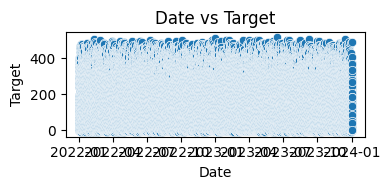

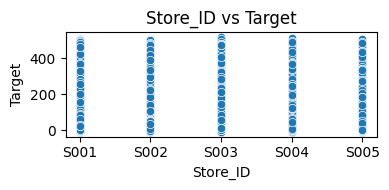

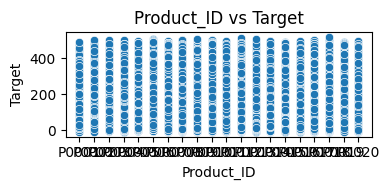

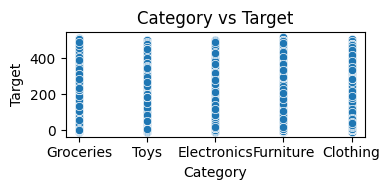

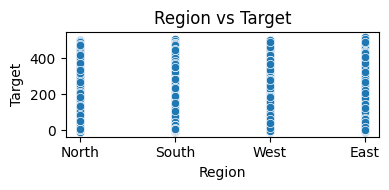

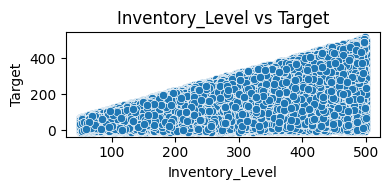

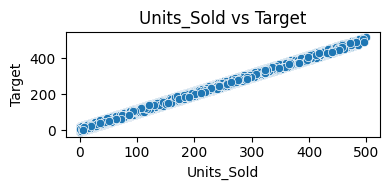

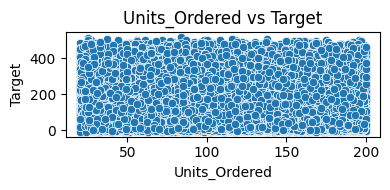

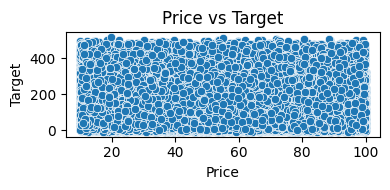

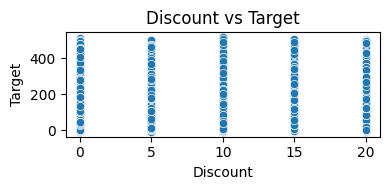

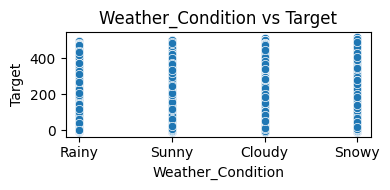

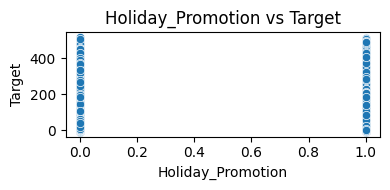

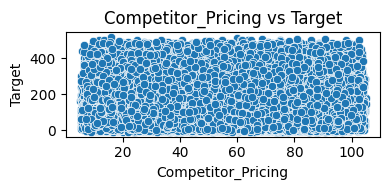

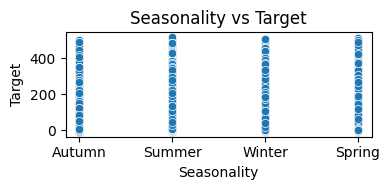

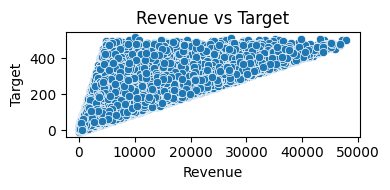

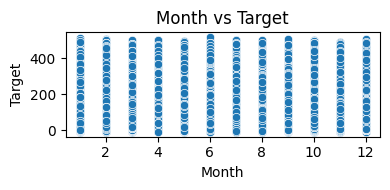

In [24]:
#Visualize feature-target relationships:

for col in X.columns:
    plt.figure(figsize=(4, 2))  # Create a new figure for each plot
    sns.scatterplot(x=X[col], y=y)
    plt.title(f"{col} vs Target")
    plt.xlabel(col)
    plt.ylabel("Target")
    plt.tight_layout()
    plt.show()

#### The target variable varies significantly within each month without a clear month-wise trend, suggesting month might not independently explain much variance in the target.

## Dropping & Renaming the columns :

In [25]:
data.columns

Index(['Date', 'Store_ID', 'Product_ID', 'Category', 'Region',
       'Inventory_Level', 'Units_Sold', 'Units_Ordered', 'Demand_Forecast',
       'Price', 'Discount', 'Weather_Condition', 'Holiday_Promotion',
       'Competitor_Pricing', 'Seasonality', 'Revenue', 'Month'],
      dtype='object')

In [26]:
data.drop(columns=['Date', 'Store_ID', 'Product_ID', 'Month'], axis=1, inplace=True)

In [27]:
data = data.rename(columns={'Inventory_Level': 'Inventory', 
                        'Units_Sold': 'Sales', 
                        'Units_Ordered': 'Orders', 
                        'Demand_Forecast': 'Demand', 
                        'Weather_Condition': 'Weather', 
                        'Holiday_Promotion': 'Promotion'})

In [28]:
data.columns

Index(['Category', 'Region', 'Inventory', 'Sales', 'Orders', 'Demand', 'Price',
       'Discount', 'Weather', 'Promotion', 'Competitor_Pricing', 'Seasonality',
       'Revenue'],
      dtype='object')

### Outliers :

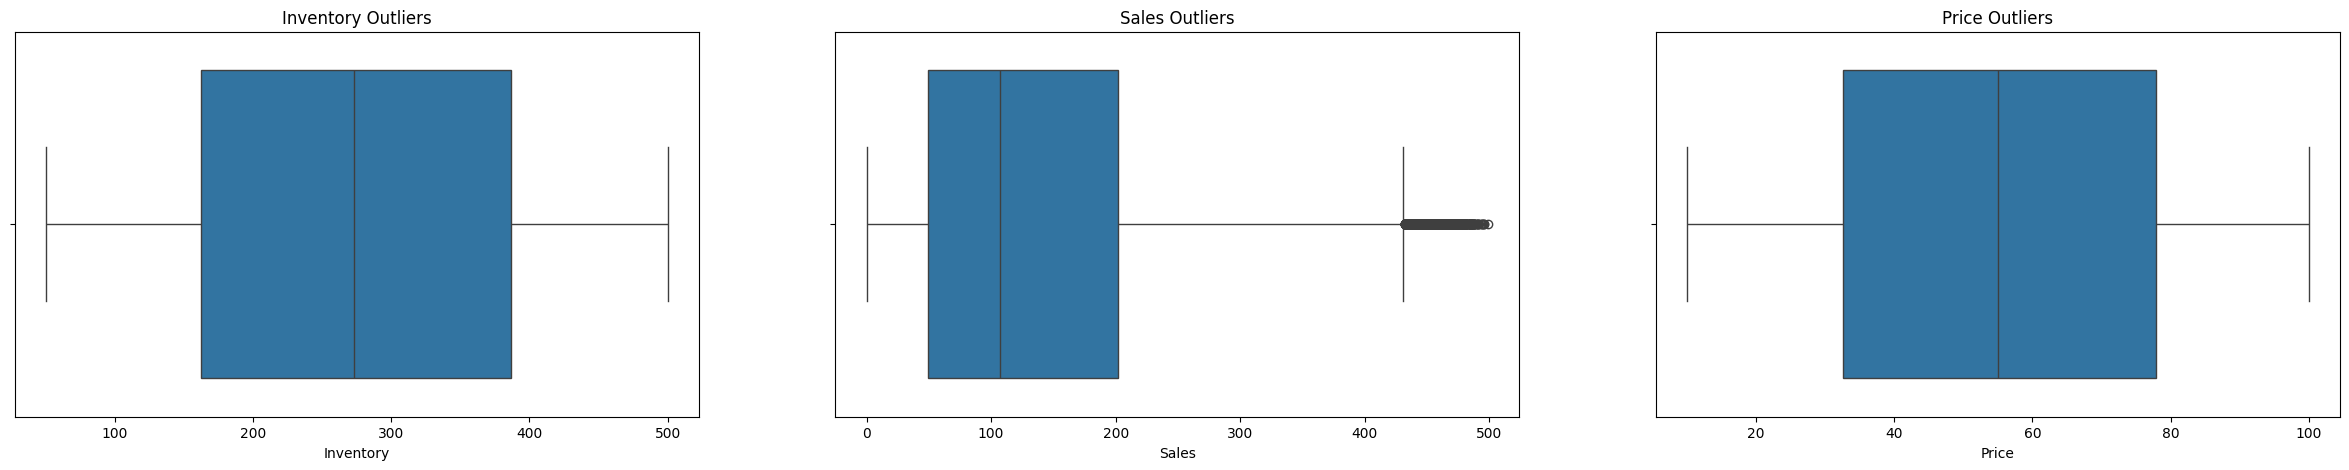

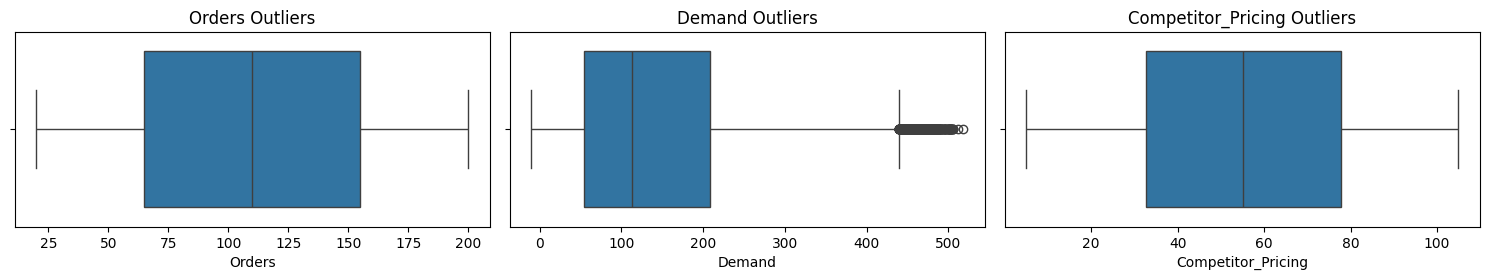

In [29]:
# Checking the outliers :

plt.figure(figsize=(30, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x=data['Inventory'])
plt.title('Inventory Outliers')

plt.subplot(1, 3, 2)
sns.boxplot(x=data['Sales'])
plt.title('Sales Outliers')

plt.subplot(1, 3, 3)
sns.boxplot(x=data['Price'])
plt.title('Price Outliers')

plt.figure(figsize=(15, 5))
plt.subplot(2, 3, 1)
sns.boxplot(x=data['Orders'])
plt.title('Orders Outliers')

plt.subplot(2, 3, 2)
sns.boxplot(x=data['Demand'])
plt.title('Demand Outliers')

plt.subplot(2, 3, 3)
sns.boxplot(x=data['Competitor_Pricing'])
plt.title('Competitor_Pricing Outliers')

plt.tight_layout()
plt.show()


In [30]:
# Treatment of the columns having outliers :

def iqr_outlier_treatment(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    return df


In [31]:
data = iqr_outlier_treatment(data, 'Sales')
data = iqr_outlier_treatment(data, 'Demand')

### Data Preprocessing :

In [34]:
# Handeling Catagorical columns by encoding them.
# We will use OneHotEncoding as our categorical columns are nominal in nature.

cat_data = data[['Category', 'Region', 'Weather', 'Promotion', 'Seasonality']]

ohe = OneHotEncoder(drop='first')
ohe = ohe.fit(cat_data)

In [35]:
transformed_data = ohe.transform(cat_data)

In [36]:
cat_data = pd.DataFrame(transformed_data.toarray(), columns=ohe.get_feature_names_out())
cat_data

,Category_Electronics,Category_Furniture,Category_Groceries,Category_Toys,Region_North,Region_South,Region_West,Weather_Rainy,Weather_Snowy,Weather_Sunny,Promotion_True,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72376,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
72377,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72378,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
72379,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [37]:
num_data = data[data.columns.difference(['Category', 'Region', 'Weather', 'Promotion', 'Seasonality', 'Demand'])]
num_data

,Competitor_Pricing,Discount,Inventory,Orders,Price,Revenue,Sales
0,29.690001,20,231,55,33.500000,4254.500000,127.0
1,66.160004,20,204,66,63.009998,9451.500000,150.0
2,31.320000,10,102,51,27.990000,1819.349976,65.0
3,34.740002,10,469,164,32.720001,1995.920044,61.0
4,68.949997,0,166,135,73.639999,1030.959961,14.0
...,...,...,...,...,...,...,...
72376,72.449997,20,96,127,73.730003,589.840027,8.0
72377,83.779999,10,313,101,82.570000,4211.069824,51.0
72378,10.910000,10,278,151,11.110000,399.959991,36.0
72379,55.799999,20,374,21,53.139999,14028.959961,264.0


In [38]:
# Checking both the numerical and encoded categorical columns shape and concat them.

print(cat_data.shape)
print(num_data.shape)

final_data = pd.concat([cat_data, num_data], axis=1)
final_data

(72381, 14)
(72381, 7)


,Category_Electronics,Category_Furniture,Category_Groceries,Category_Toys,Region_North,Region_South,Region_West,Weather_Rainy,Weather_Snowy,Weather_Sunny,...,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter,Competitor_Pricing,Discount,Inventory,Orders,Price,Revenue,Sales
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,29.690001,20,231,55,33.500000,4254.500000,127.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,66.160004,20,204,66,63.009998,9451.500000,150.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,31.320000,10,102,51,27.990000,1819.349976,65.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,34.740002,10,469,164,32.720001,1995.920044,61.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,68.949997,0,166,135,73.639999,1030.959961,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72376,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,72.449997,20,96,127,73.730003,589.840027,8.0
72377,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,83.779999,10,313,101,82.570000,4211.069824,51.0
72378,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,10.910000,10,278,151,11.110000,399.959991,36.0
72379,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,55.799999,20,374,21,53.139999,14028.959961,264.0


<Axes: xlabel='Demand_Forecast', ylabel='Count'>

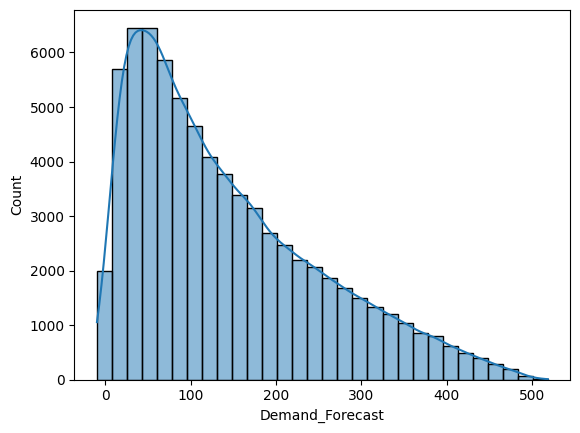

In [39]:
sns.histplot(y,
             bins=30,
             kde=True)

<Axes: xlabel='Demand_Forecast', ylabel='Count'>

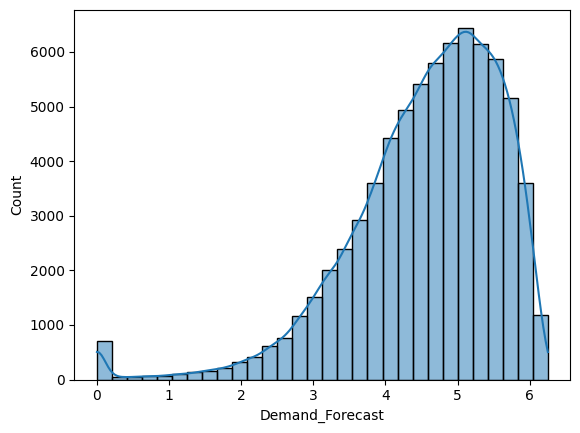

In [40]:
# Apply log1p to avoid issues with zero (log1p(x) = log(1+x))
# y_nn is basically non negative y as all the negative values of y are clipped with 0.
y_nn = y.clip(lower=0)

y_log = np.log1p(y_nn)
sns.histplot(y_log,
             bins=30,
             kde=True)

In [41]:
# Scaling the Data :

scaler = StandardScaler()
X = scaler.fit_transform(final_data)
X

array([[-0.49800886, -0.50180836,  2.00122698, ..., -0.83119139,
        -0.4339431 , -0.08492895],
       [-0.49800886, -0.50180836, -0.49969344, ...,  0.30270322,
         0.25536108,  0.12767445],
       [-0.49800886, -0.50180836, -0.49969344, ..., -1.0429081 ,
        -0.75692927, -0.65803379],
       ...,
       [-0.49800886, -0.50180836, -0.49969344, ..., -1.69150661,
        -0.94519008, -0.92609896],
       [-0.49800886, -0.50180836, -0.49969344, ..., -0.07654244,
         0.86249256,  1.18144787],
       [-0.49800886, -0.50180836,  2.00122698, ...,  0.89366565,
        -0.93585523, -1.20340775]])

In [42]:
X = pd.DataFrame(X, columns=final_data.columns)

In [43]:
from sklearn.feature_selection import RFE

# Feature selection using RandomForest Regressor estimator :
from sklearn.ensemble import RandomForestRegressor

model1 = DecisionTreeRegressor()
rfe  = RFE(estimator = model1, n_features_to_select=10)


In [44]:
rfe.fit(X, y)

RFE(estimator=DecisionTreeRegressor(), n_features_to_select=10)

In [46]:
X.columns[rfe.support_]

Index(['Weather_Snowy', 'Promotion_True', 'Seasonality_Winter',
       'Competitor_Pricing', 'Discount', 'Inventory', 'Orders', 'Price',
       'Revenue', 'Sales'],
      dtype='object')

In [47]:
# Feature selection using RandomForest Regressor estimator :

from sklearn.feature_selection import SelectKBest, f_regression

model2 = f_regression
skb = SelectKBest(model2, k=15)


In [48]:
skb = skb.fit(X,y)

In [49]:
X.columns[skb.get_support()]

Index(['Category_Electronics', 'Category_Furniture', 'Category_Toys',
       'Region_South', 'Region_West', 'Weather_Rainy', 'Weather_Snowy',
       'Weather_Sunny', 'Seasonality_Spring', 'Seasonality_Summer',
       'Seasonality_Winter', 'Discount', 'Inventory', 'Revenue', 'Sales'],
      dtype='object')

In [51]:
# Now selecting what is common between both the methods :

X_new = X[list(set(list(X.columns[rfe.support_]) + list(X.columns[skb.get_support()])))]
X_new

,Seasonality_Spring,Orders,Price,Discount,Weather_Snowy,Inventory,Seasonality_Winter,Category_Toys,Region_South,Seasonality_Summer,Competitor_Pricing,Weather_Rainy,Region_West,Category_Electronics,Sales,Revenue,Weather_Sunny,Category_Furniture,Promotion_True
0,-0.578345,-1.051864,-0.831191,1.410851,-0.577090,-0.334776,-0.577409,-0.500449,-0.577834,-0.577941,-0.971682,1.733088,-0.576281,-0.498009,-0.084929,-0.433943,-0.577983,-0.501808,-0.994997
1,-0.578345,-0.841513,0.302703,1.410851,-0.577090,-0.542616,-0.577409,1.998206,1.730600,-0.577941,0.420582,-0.577005,-0.576281,-0.498009,0.127674,0.255361,1.730154,-0.501808,-0.994997
2,-0.578345,-1.128355,-1.042908,-0.001034,-0.577090,-1.327788,-0.577409,1.998206,-0.577834,1.730282,-0.909456,-0.577005,1.735263,-0.498009,-0.658034,-0.756929,1.730154,-0.501808,1.005028
3,-0.578345,1.032523,-0.861162,-0.001034,-0.577090,1.497292,-0.577409,1.998206,-0.577834,-0.577941,-0.778895,-0.577005,-0.576281,-0.498009,-0.695008,-0.733510,-0.577983,-0.501808,1.005028
4,-0.578345,0.477961,0.711151,-1.412919,-0.577090,-0.835131,-0.577409,-0.500449,-0.577834,1.730282,0.527092,-0.577005,-0.576281,2.007996,-1.129459,-0.861497,1.730154,-0.501808,-0.994997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72376,-0.578345,0.324979,0.714610,1.410851,1.732833,-1.373975,1.731875,-0.500449,-0.577834,-0.577941,0.660706,-0.577005,-0.576281,-0.498009,-1.184921,-0.920005,-0.577983,1.992793,-0.994997
72377,-0.578345,-0.172214,1.054278,-0.001034,-0.577090,0.296441,-0.577409,1.998206,-0.577834,-0.577941,1.093236,-0.577005,-0.576281,-0.498009,-0.787445,-0.439703,-0.577983,-0.501808,-0.994997
72378,-0.578345,0.783926,-1.691507,-0.001034,-0.577090,0.027019,1.731875,-0.500449,-0.577834,-0.577941,-1.688620,1.733088,1.735263,-0.498009,-0.926099,-0.945190,-0.577983,-0.501808,-0.994997
72379,1.729073,-1.702039,-0.076542,1.410851,-0.577090,0.766005,-0.577409,1.998206,-0.577834,-0.577941,0.025083,1.733088,-0.576281,-0.498009,1.181448,0.862493,-0.577983,-0.501808,-0.994997


In [52]:
# To use the selected feature I'm creating same variable.
# If you want to run the models on all the features, just re-run the cell where the Standaredisation is happening.

X = X_new

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 17)

In [54]:
print(X_train.shape)
print(X_test.shape)

(57904, 19)
(14477, 19)


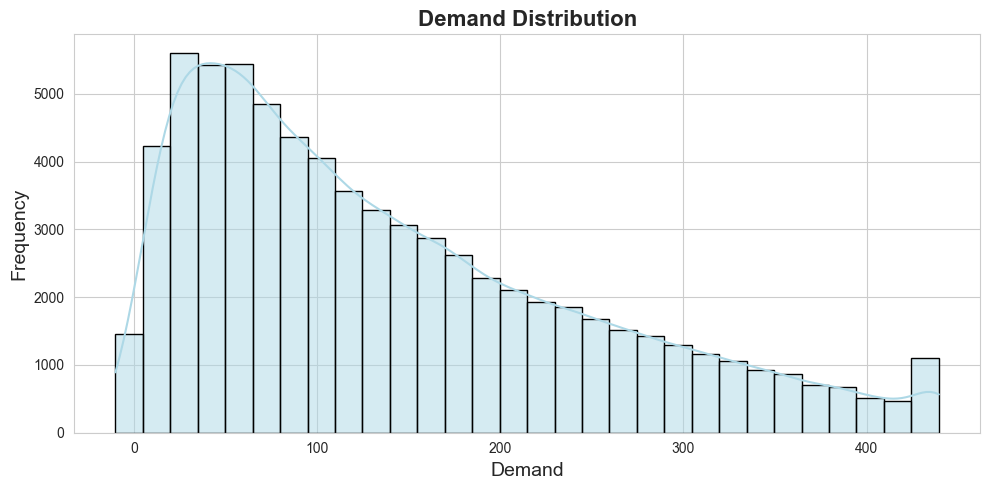

In [55]:
# Let's see how my demand is distributed over the years.

plt.figure(figsize=(10,5))
sns.set_style("whitegrid")

sns.histplot(data['Demand'],
             bins=30,
             kde=True,
             color='lightblue',
             edgecolor='black',
             #kde_kws={'color': 'red', 'linewidth': 2}
            ) 

plt.title('Demand Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Demand', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()

#### The histogram fig of Demand provides a visual representation of the demand distribution. From the histogram, we can infer:

    Skewed Distribution: The demand distribution is skewed to the right, indicating that there are more instances of higher demand.

    Peak Demand: The histogram shows a peak around the median demand (113.02 units), indicating that most of the demand is concentrated around this value.

    Variation in Demand: The histogram also shows a significant variation in demand, with some instances of very high demand (above 400 units) and some instances of low demand (below 50 units).

## Data Modeling :

In [56]:
from tabulate import tabulate

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Calculate metrics
    train_r2 = model.score(X_train, y_train)
    y_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Prepare the table data
    metrics = [
        ["Training R² Score", f"{train_r2:.4f}"],
        ["Testing R² Score", f"{test_r2:.4f}"],
        ["Mean Squared Error (MSE)", f"{mse:.2f}"],
        ["Root Mean Squared Error (RMSE)", f"{rmse:.2f}"],
        ["Mean Absolute Error (MAE)", f"{mae:.2f}"],
    ]
    
    # Print the table
    print(tabulate(metrics, headers=["Metric", "Value"], tablefmt="grid"))

### Linear Regression

In [57]:
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

In [58]:
# Evaluate the model

evaluate_model(lr, X_train, y_train, X_test, y_test)

+--------------------------------+---------+
| Metric                         |   Value |
+================================+=========+
| Training R² Score              |  0.993  |
+--------------------------------+---------+
| Testing R² Score               |  0.9932 |
+--------------------------------+---------+
| Mean Squared Error (MSE)       | 81.78   |
+--------------------------------+---------+
| Root Mean Squared Error (RMSE) |  9.04   |
+--------------------------------+---------+
| Mean Absolute Error (MAE)      |  7.65   |
+--------------------------------+---------+


### Support Vector Regression

In [59]:
svr = SVR()

svr.fit(X_train, y_train)

SVR()

In [61]:
# Evaluate the model

evaluate_model(svr, X_train, y_train, X_test, y_test)

+--------------------------------+----------+
| Metric                         |    Value |
+================================+==========+
| Training R² Score              |   0.9799 |
+--------------------------------+----------+
| Testing R² Score               |   0.9807 |
+--------------------------------+----------+
| Mean Squared Error (MSE)       | 231.91   |
+--------------------------------+----------+
| Root Mean Squared Error (RMSE) |  15.23   |
+--------------------------------+----------+
| Mean Absolute Error (MAE)      |  10.8    |
+--------------------------------+----------+


### Decision Tree Regressor

In [62]:
DT = DecisionTreeRegressor()

DT.fit(X_train, y_train)

DecisionTreeRegressor()

In [63]:
# Evaluate the model

evaluate_model(DT, X_train, y_train, X_test, y_test)

+--------------------------------+----------+
| Metric                         |    Value |
+================================+==========+
| Training R² Score              |   1      |
+--------------------------------+----------+
| Testing R² Score               |   0.9867 |
+--------------------------------+----------+
| Mean Squared Error (MSE)       | 159.63   |
+--------------------------------+----------+
| Root Mean Squared Error (RMSE) |  12.63   |
+--------------------------------+----------+
| Mean Absolute Error (MAE)      |  10.25   |
+--------------------------------+----------+


### KNeighbors Regressor

In [64]:
KNR = KNeighborsRegressor()

KNR.fit(X_train,y_train)

KNeighborsRegressor()

In [65]:
# Evaluate the model

evaluate_model(KNR, X_train, y_train, X_test, y_test)

+--------------------------------+-----------+
| Metric                         |     Value |
+================================+===========+
| Training R² Score              |    0.9376 |
+--------------------------------+-----------+
| Testing R² Score               |    0.9028 |
+--------------------------------+-----------+
| Mean Squared Error (MSE)       | 1165.37   |
+--------------------------------+-----------+
| Root Mean Squared Error (RMSE) |   34.14   |
+--------------------------------+-----------+
| Mean Absolute Error (MAE)      |   26.56   |
+--------------------------------+-----------+


## Model Analysis & Best Model Selection

### LinearRegression
    Training R² Score: 0.993
    Testing R² Score: 0.9932
    MSE: 81.78
    RMSE: 9.04
    MAE: 7.65
    This model provided excellent performance, with low errors and high consistency between training and testing scores, suggesting a well-fitting model.

### SVR (Support Vector Regression)
    Training R² Score: 0.9799
    Testing R² Score: 0.9807
    MSE: 231.91
    RMSE: 15.23
    MAE: 10.8
    The SVR model showed good performance but had higher errors compared to LinearRegression. It captures non-linear relationships but does not outperform LinearRegression.

### DecisionTreeRegressor
    Training R² Score: 1
    Testing R² Score: 0.9867
    MSE: 159.63
    RMSE: 12.63
    MAE: 10.25
    This model exhibited overfitting (perfect Training R² score) but performed decently on the test set. The errors are higher than LinearRegression, indicating it may not generalize as well.

### KNeighborsRegressor
    Training R² Score: 0.9376
    Testing R² Score: 0.9028
    MSE: 1165.37
    RMSE: 34.14
    MAE: 26.56
    This model had the worst performance, with the highest error rates and the lowest R² scores. It does not capture the data patterns as effectively as the other models.


## Best Model: LinearRegression ¶
    Based on the evaluation metrics, LinearRegression is the best model for predicting demand in the retail store dataset. It provides:

    The highest Testing R² score (0.9932)
    The lowest error rates (MSE = 81.78, RMSE = 9.04, MAE = 7.65)
    Consistent performance between training and testing, indicating no overfitting or underfitting.
### Therefore, LinearRegression is the most reliable choice for this dataset.

## Saving (Dumping) the Model & Loading (Reading) the Model Later :

In [66]:
# Saving the model :

import pickle
with open("E:\AnalytixLAB Internship\Project 5 Materials (Everything)\Retail Store Inventory\linear_regression_model.pkl", "wb") as file:
    pickle.dump(lr, file)


#### #Later load model
    with open('linear_regression_model.pkl', 'rb') as file:
        loaded_model = pickle.load(file)

#### #Use loaded model
    y_pred = loaded_model.predict(X_test)

# ------------------------------------THANK YOU-----------------------------------